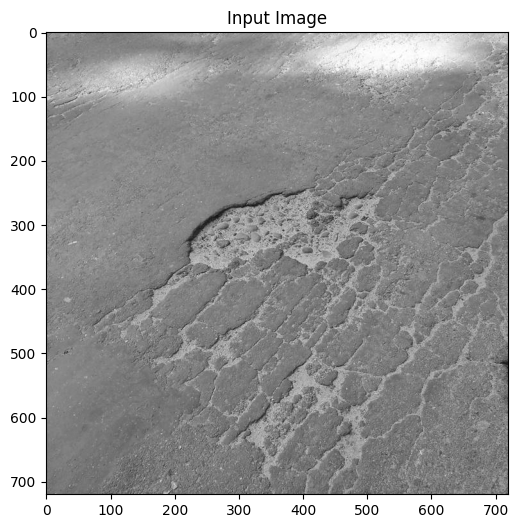

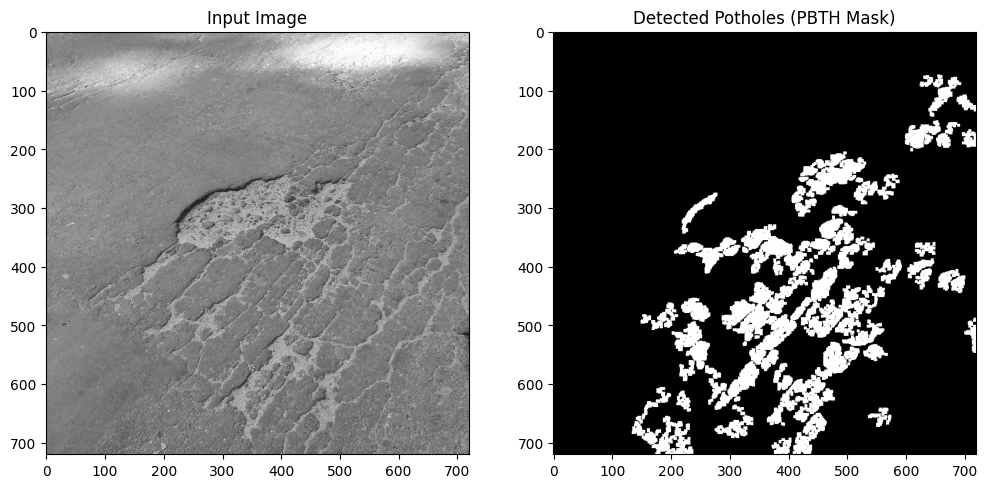

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def pbth_pothole_detection(image_path, r0=5, r_final=50, delta_r=5, threshold=50):
    """
    Detect potholes using the Progressive Black Top-Hat (PBTH) algorithm.

    Parameters:
        image_path (str): Path to the input image (grayscale or topographic).
        r0 (int): Initial radius for structuring element.
        r_final (int): Maximum radius for structuring element.
        delta_r (int): Incremental radius step.
        threshold (int): Threshold value for binary mask generation.

    Returns:
        numpy.ndarray: Binary mask highlighting pothole regions.
    """
    # Step 1: Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    plt.figure(figsize=(6, 6))
    plt.title("Input Image")
    plt.imshow(image, cmap="gray")
    plt.show()
    
    # Normalize the image to 0-255 (if not already normalized)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    # Initialize variables for PBTH
    pbth_mask = np.zeros_like(image, dtype=np.uint8)  # Combined mask
    current_radius = r0

    # Step 2: Progressive Black Top-Hat
    while current_radius <= r_final:
        # Create a circular structuring element
        structuring_element = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE, (current_radius, current_radius)
        )

        # Apply Black Top-Hat transformation
        top_hat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, structuring_element)

        # Threshold the top-hat result to identify regions
        _, binary_mask = cv2.threshold(top_hat, threshold, 255, cv2.THRESH_BINARY)

        # Combine the binary mask with the progressive mask
        pbth_mask = cv2.bitwise_or(pbth_mask, binary_mask)

        # Increment the radius
        current_radius += delta_r

    # Step 3: Post-processing
    # Remove small noise by applying morphological opening
    cleaned_mask = cv2.morphologyEx(pbth_mask, cv2.MORPH_OPEN, 
                                     cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))

    # Remove small isolated regions (optional)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(cleaned_mask)
    min_area = 500  # Minimum area threshold for connected components
    final_mask = np.zeros_like(cleaned_mask)
    for i in range(1, num_labels):  # Skip background (label 0)
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            final_mask[labels == i] = 255

    return final_mask


# ==========================================
# Step 4: Run the PBTH Algorithm
# ==========================================
image_path = r'D:\Myproject\Pothole Dataset\Images\img-1.jpg'  # Replace with your input image path
pothole_mask = pbth_pothole_detection(image_path)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Detected Potholes (PBTH Mask)")
plt.imshow(pothole_mask, cmap="gray")
plt.show()
